In [1]:
import os, torch, joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import *
from utils import *
from data_loader import *
from test_metrics import *
from preprocess.gaussianize import *
from scipy.stats import wasserstein_distance
from statsmodels.tsa.stattools import acf

path = '/workspace/QuantGAN_stock'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))
    
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(0)
sns.set(style="darkgrid")


Directory /workspace/QuantGAN_stock does not exist


In [3]:
# Define the Configuration
full_name = 'indices_num_G_5_200_128_lr_0.0001'
data_name = 'indices'
sector = 'mvfit-gan'

num_G = 5
seq_len = 128
batch_size = 500

In [7]:
# Load the Real Data for Transformer input
log_returns_preprocessed = joblib.load(f'../Dataset/pickle/{data_name}_log_returns_preprocessed.pkl')
data_loader = dataloader(log_returns_preprocessed, seq_len)    
train_loader = torch.utils.data.DataLoader(data_loader, batch_size, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../Dataset/pickle/indices_log_returns_preprocessed.pkl'

In [5]:
# Find the best epoch
window = 1
asset_idx = 0
min_emd = 0
best_epochs = 0

min_distance = float('inf')
noise = torch.randn(batch_size, 3, seq_len).to(device)

for epoch in range(190, 200, 2):    
    
    generator_tmp = Generator().to(device)
    generator_tmp.load_state_dict(torch.load(f'./Results/{full_name}/Generator_{epoch}.pt'))
    generator_tmp.eval()
    
    y = generator_tmp(noise).cpu().detach()
    y, log_returns = inverse_process(y[:, asset_idx:asset_idx+1, :].squeeze(), asset_idx, data_name)
    if y.size == 0:            
        continue
    
    real_dist = rolling_window(log_returns, window).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, window).sum(axis=0).ravel()       
    
    emd = wasserstein_distance(real_dist, fake_dist)
    if emd < min_distance:
        min_distance = emd
        best_epochs = epoch
        min_emd = min_distance
        print(f"min_distance:{min_distance}, best_epochs:{epoch}")
        
    # 메모리 해제
    del generator_tmp, y, log_returns, real_dist, fake_dist
    torch.cuda.empty_cache()
    
print("best epochs:", best_epochs)

min_distance:0.0010863483609783039, best_epochs:190
min_distance:0.0008620527356047907, best_epochs:192
min_distance:0.00046549991708912705, best_epochs:194
min_distance:0.00044877862510544857, best_epochs:196
best epochs: 196


In [6]:
# generate the data based on best epoch
generator = Generator().to(device)
generator.load_state_dict(torch.load(f'./Results/{full_name}/Generator_{best_epochs}.pt'))
generator.eval()

Generator(
  (tcn): ModuleList(
    (0): TemporalBlock(
      (conv1): Conv1d(3, 80, kernel_size=(1,), stride=(1,))
      (bn1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (chomp1): Chomp1d()
      (relu1): PReLU(num_parameters=1)
      (dropout1): Dropout(p=0.1, inplace=False)
      (conv2): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      (bn2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (chomp2): Chomp1d()
      (relu2): PReLU(num_parameters=1)
      (dropout2): Dropout(p=0.1, inplace=False)
      (net): Sequential(
        (0): Conv1d(3, 80, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Dropout(p=0.1, inplace=False)
        (4): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
        (5): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [7]:
# fake_list = []
# real_list = []
# real = []

# with torch.no_grad():
#     noise = torch.randn(3000, 3, seq_len).to(device)
#     fake = generator(noise).cpu().detach()

#     for i in range(0, num_G):
#         y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i, data_name)
#         y_tmp = y_tmp[(y_tmp.max(axis=1) <= 2.0 * log_returns.max()) & (y_tmp.min(axis=1) >= 2.0 * log_returns.min())]        
#         print(y_tmp.shape)
#         y_tmp = y_tmp[:1000, :]
#         print(y_tmp.shape)
        
#         fake_list.append(y_tmp)
#         real.append(log_returns)
        
#         # 메모리 해제
#         del y_tmp, log_returns
#         torch.cuda.empty_cache()

# for i in range(len(real)):
#     real_list.append(np.array(rolling_window_seqlen(real[i], seq_len)).squeeze())

# # 합성 데이터 저장
# #joblib.dump(fake_list, './Output/fake_list.pkl')
# #joblib.dump(real_list, './Output/real_list.pkl')

# # csv 파일로 저장
# df = pd.DataFrame(np.array(fake_list).squeeze())
# df.to_csv(f'./Output/{sector}/{data_name}_QuantGAN.csv', index=True)

In [8]:
""" 5000개 샘플을 생성하기 위해 """
fake_list = []
real_list = []
real = []

with torch.no_grad():
    for j in range(10):
        noise = torch.randn(2000, 3, seq_len).to(device)
        fake = generator(noise).cpu().detach()

        for i in range(0, num_G):
            y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i, data_name)
            y_tmp = y_tmp[(y_tmp.max(axis=1) <= 2.0 * log_returns.max()) & (y_tmp.min(axis=1) >= 2.0 * log_returns.min())]        
            print(y_tmp.shape)
            y_tmp = y_tmp[:1000, :]
            print(y_tmp.shape)
            
            fake_list.append(y_tmp)
            if j == 0:
                real.append(log_returns)
                    

for i in range(len(real)):
    real_list.append(np.array(rolling_window_seqlen(real[i], seq_len)).squeeze())

# 합성 데이터 저장
#joblib.dump(fake_list, './Output/fake_list.pkl')
#joblib.dump(real_list, './Output/real_list.pkl')

# csv 파일로 저장
reshaped_array = np.array(fake_list)
df = pd.DataFrame(reshaped_array.reshape(-1, reshaped_array.shape[2]).squeeze())
print(df.shape)
df.to_csv(f'./Output/{sector}/{data_name}_QuantGAN.csv', index=True)

(2000, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(1999, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(1998, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(2000, 126)
(1000, 126)
(10000, 126)


In [9]:
print(real[0].shape)
print(real_list[0].shape)

fake_tmp = np.vstack(fake_list)
fake_list = []
fake_list.append(fake_tmp)
print(fake_list[0].shape)


(4887, 1)
(4761, 126)
(10000, 126)


In [10]:
# print(type(real))
# print(len(real), real[0].shape, '\n')

# print(type(real_list))
# print(len(real_list), real_list[0].shape, '\n')

# print(type(fake_list))
# print(len(fake_list), fake_list[0].shape)

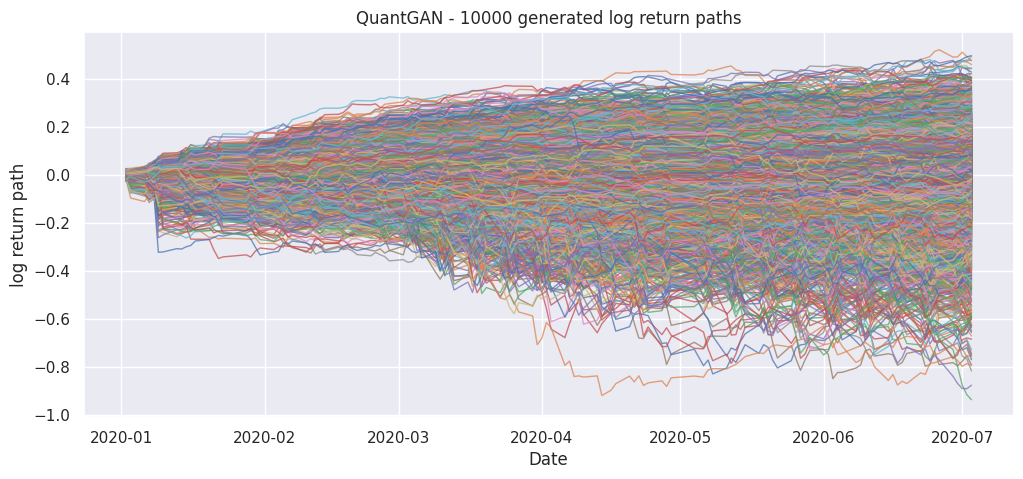

In [11]:
# # plot the 30 generated log return paths
for i in range(1):
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(trading_days, np.cumsum(fake_list[i][0:10000], axis=1).T, alpha=0.75, linewidth=1.0)
    ax.set_title('QuantGAN - 10000 generated log return paths')
    ax.set_xlabel('Date')

    ax.set_ylabel('log return path')

In [12]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Calculate EMD scores
results_emd = calculate_distribution_scores(real, fake_list, num_G, windows)
results_emd

{'EMD':               EMD 0  EMD_avg
 window size                 
 1            0.0004   0.0004
 5            0.0010   0.0010
 20           0.0013   0.0013
 100          0.0095   0.0095,
 'KL':                KL 0
 window size        
 1            0.0154
 5            0.0118
 20           0.0128
 100          0.1100,
 'JS':                JS 0
 window size        
 1            0.0597
 5            0.0509
 20           0.0580
 100          0.0863,
 'KS':                KS 0
 window size        
 1            0.0200
 5            0.0153
 20           0.0166
 100          0.0319}

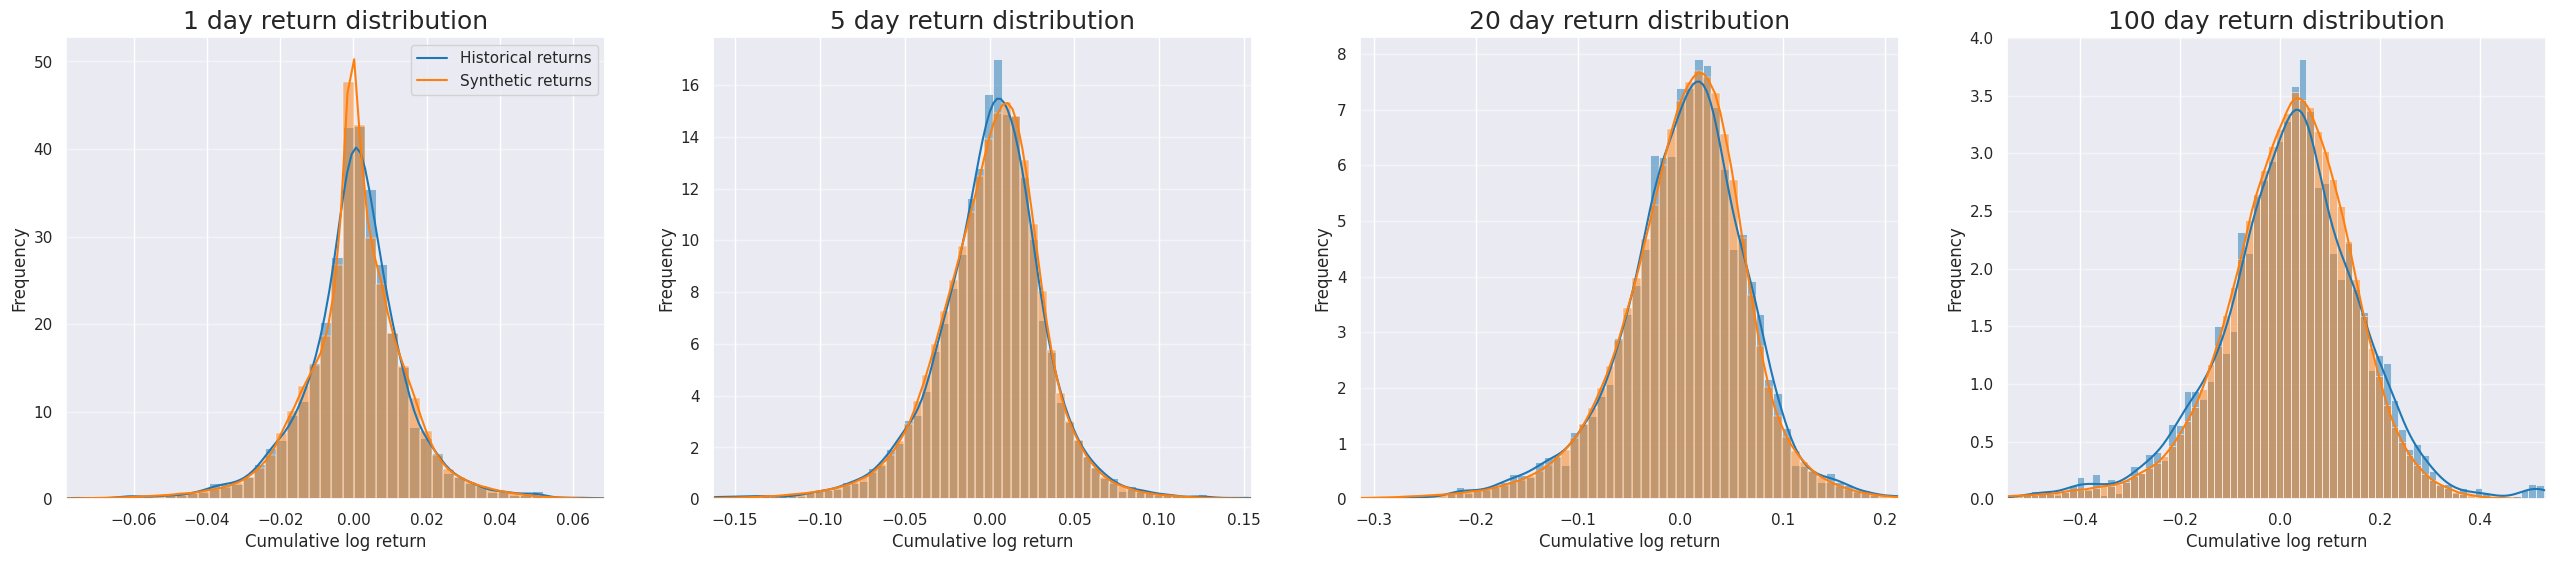

In [13]:
windows = [1, 5, 20, 100]
for j in range(num_G):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
        # 두 데이터의 최소값과 최대값을 계산
        min_val = real_dist.min()
        max_val = real_dist.max()

        # 동일한 bin 경계 계산 (간격 동일하게)
        bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
        sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))

        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])

plt.savefig(f'./Output/{sector}/{data_name}_QuantGAN.png', format='png', dpi=300, bbox_inches='tight')  
plt.show()

In [14]:
# # Correlation Analysis of synthetic data
# df_fake = []        
# for i in range(num_G):
    
#     y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i)        
#     df_tmp = pd.DataFrame(y_tmp)
#     df_fake.append(df_tmp)
    
# df_fake_merge = pd.concat(df_fake, axis=1)

# corr_fake, avg_fake, _ = calculate_correlation(df_fake_merge, seq_len)

# ### Correlation Analysis - real data
# real_merge = np.transpose(np.stack(real_list), axes=(1, 0, 2))
# real_merge = real_merge.reshape(real_merge.shape[0], -1)
# df_real_merge = pd.DataFrame(real_merge)
# _, avg_real, _ = calculate_correlation(df_real_merge, seq_len)

In [15]:
# mae = calculate_mae(avg_real, avg_fake)
# #mae_mean, mae_std = calculate_mae_mean(avg_real, corr_fake)

# frobenius = calculate_frobenius(avg_real, avg_fake)
# spearman = calculate_spearman(avg_real, avg_fake)
# kendall = calculate_kendall(avg_real, avg_fake)


# print("MAE mean:", mae)
# print("Frobenius", frobenius)
# print("Spearman", spearman)
# print("Kendall:", kendall)
# #print("MAE mean:", mae_mean, "MAE std:", mae_std)

In [16]:
# print(avg_real)
# print(avg_fake)

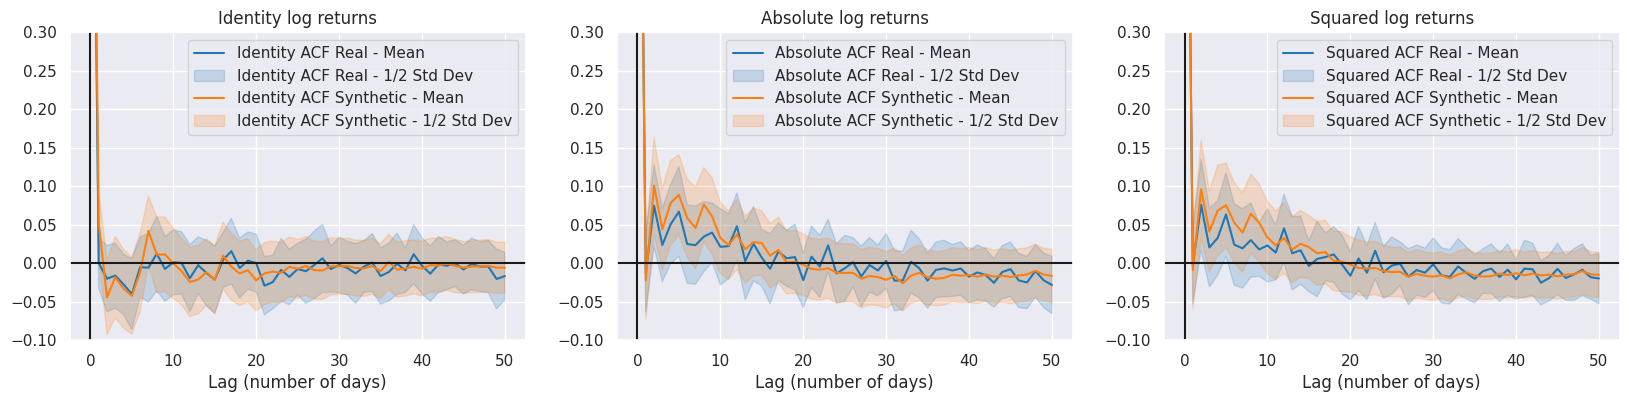

In [17]:
# ACF 비교 플롯
plot_acf_comparison(real_list, fake_list, num_G, lags=50)

In [18]:
acf_score = calculate_acf_score(real_list, fake_list)

# Display the scores for each group
for group, scores in acf_score.items():
    print(f"{group}:")
    for title, score in scores.items():
        print(f"  {title}: {score}")



Group 1:
  Identity log returns: 0.099
  Absolute log returns: 0.1075
  Squared log returns: 0.0961


In [19]:
print(len(real_list))

1


In [20]:
print(fake_list[0].shape)
print(real_list[0].shape)

print(real)

(10000, 126)
(4761, 126)
[array([[-0.07614739],
       [-0.02501559],
       [-0.01417285],
       ...,
       [ 0.00395259],
       [ 0.00386931],
       [-0.00485602]])]


In [21]:
calculate_skew_kurt_diff(fake_list, real_list)
calculate_skew_kurt_diff_tot(fake_list, log_returns)


Asset 1 Statistics:
  Fake Data (Daily) - Mean: 0.00013, Median: 0.00035, Std Dev: 0.01503
  Fake Data (Annualized) - Mean: 0.03193, Median: 0.08874, Std Dev: 0.23855
  Real Data (Daily) - Mean: 0.00020, Median: 0.00067, Std Dev: 0.01518
  Real Data (Annualized) - Mean: 0.05049, Median: 0.16834, Std Dev: 0.24096
  Fake Data - Skewness: -0.21983, Kurtosis: 4.18912
  Real Data - Skewness: -0.26520, Kurtosis: 4.27076
  Skewness Difference: 0.0454
  Kurtosis Difference: 0.0816
Asset 1 Statistics:
  Fake Data (Daily) - Mean: 0.00013, Median: 0.00035, Std Dev: 0.01503
  Fake Data (Annualized) - Mean: 0.03193, Median: 0.08874, Std Dev: 0.23855
  Real Data (Daily) - Mean: 0.00016, Median: 0.00065, Std Dev: 0.01541
  Real Data (Annualized) - Mean: 0.04061, Median: 0.16276, Std Dev: 0.24460
  Fake Data - Skewness: -0.21983, Kurtosis: 4.18912
  Real Data - Skewness: -0.47634, Kurtosis: 9.38220


[]

In [22]:
# calculate_leverage_effect(fake_list, real_list)

In [23]:
# def calculate_acf_score_120(real_list, fake_list, lags=40):
#     data_transforms = [lambda x: x, np.abs, np.square]  # Identity 변환 추가
#     titles = ['Identity log returns', 'Absolute log returns', 'Squared log returns']
#     acf_scores = {}
    
#     n_groups = len(real_list)
    
#     for i in range(n_groups):
#         group_scores = {}
        
#         for transform, title in zip(data_transforms, titles):
#             transformed_real = transform(real_list[i])
#             transformed_fake = transform(fake_list[i])
            
#             # transformed_real = transformed_real[:, -120:]
#             # transformed_fake = transformed_fake[:, -120:]            
            
#             acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
#             acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
            
#             mean_real = np.mean(acf_real, axis=0)
#             mean_fake = np.mean(acf_fake, axis=0)
#             std_real = np.std(acf_real, axis=0)
#             std_fake = np.std(acf_fake, axis=0)
    
#             group_scores[title] = {
#                 'mean': np.round(np.linalg.norm(mean_real - mean_fake), decimals=4),
#                 'std': np.round(np.linalg.norm(std_real - std_fake), decimals=4)
#             }
        
#         acf_scores[f'Group {i+1}'] = group_scores
    
#     # 각 변환별로 모든 그룹의 mean과 std의 평균 계산
#     avg_scores = {}
#     for title in titles:
#         mean_avg = np.mean([acf_scores[f'Group {i+1}'][title]['mean'] for i in range(n_groups)])
#         std_avg = np.mean([acf_scores[f'Group {i+1}'][title]['std'] for i in range(n_groups)])
        
#         avg_scores[title] = {
#             'mean_avg': np.round(mean_avg, decimals=4),
#             'std_avg': np.round(std_avg, decimals=4)
#         }
    
#     return acf_scores, avg_scores


# # ACF 점수 계산 함수 호출
# acf_scores, avg_scores = calculate_acf_score_120(real_list, fake_list, lags=40)

# # 각 그룹의 ACF 점수 출력
# # for group, scores in acf_scores.items():
# #     print(f"Results for {group}:")
# #     for title, values in scores.items():
# #         print(f"  {title}:")
# #         print(f"    Mean: {values['mean']}")
# #         print(f"    Std: {values['std']}")
# #     print("\n")

# # 각 변환별 전체 평균 점수 출력
# print("Average Scores across all groups:")
# for title, values in avg_scores.items():
#     print(f"  {title}:")
#     print(f"    Mean Average: {values['mean_avg']}")
#     print(f"    Std Average: {values['std_avg']}")

In [24]:
# def calculate_leverage_effect_120(real_list, fake_list, lags=40):
#     def leverage_effect(ts, tau):
#         rt = ts[:-tau]  # rt: 시계열에서 뒤에서 tau만큼 제외한 것
#         rt_squared = (ts[tau:]**2)  # rt_tau_squared: 시계열에서 앞에서 tau만큼 제외하고 제곱한 것
#         return np.corrcoef(rt, rt_squared)[0, 1]

#     n_groups = len(real_list)
#     leverage_scores = {}

#     for i in range(n_groups):
#         real_data = real_list[i]
#         fake_data = fake_list[i]
        
#         # real_data = real_data[:, -120:]
#         # fake_data = fake_data[:, -120:]

#         real_leverage_effects = np.array([[leverage_effect(ts, tau) for tau in range(1, lags+1)] for ts in real_data])
#         fake_leverage_effects = np.array([[leverage_effect(ts, tau) for tau in range(1, lags+1)] for ts in fake_data])

#         mean_real_leverage = np.mean(real_leverage_effects, axis=0)
#         mean_fake_leverage = np.mean(fake_leverage_effects, axis=0)
        
#         leverage_score = np.linalg.norm(mean_real_leverage - mean_fake_leverage)
        
#         leverage_scores[f'Group {i+1}'] = np.round(leverage_score, decimals=4)
        
#         # Print the result for the current group
#         print(f'Group {i+1} leverage score: {leverage_scores[f"Group {i+1}"]}')
#     # Calculate and print the average leverage score across all groups
#     average_leverage_score = np.mean(list(leverage_scores.values()))
#     print(f'Average leverage score across all groups: {np.round(average_leverage_score, decimals=4)}')

#     return leverage_scores

# calculate_leverage_effect_120(fake_list, real_list, lags=40)

In [25]:
# from matplotlib.ticker import MaxNLocator

# windows = [1, 20, 100]
# for j in range(5):
#     fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))  

#     for i in range(len(windows)):
#         ax = axs[i]  # 올바른 서브플롯 선택

#         real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
#         fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
#         # 두 데이터의 최소값과 최대값을 계산
#         min_val = real_dist.min()
#         max_val = real_dist.max()

#         # 동일한 bin 경계 계산 (간격 동일하게)
#         bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
#         sns.histplot(real_dist, bins=bins, kde=True, ax=ax, color='tab:blue', alpha=0.5, stat='density')
#         sns.histplot(fake_dist, bins=bins, kde=True, ax=ax, color='tab:orange', alpha=0.5, stat='density')

#         ax.set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
#         ax.tick_params(axis='x', labelsize=13)
#         ax.tick_params(axis='y', labelsize=13)
#         ax.yaxis.grid(True, alpha=0.5)
#         ax.set_xlabel('Cumulative log return', fontsize=14)
#         ax.set_ylabel('Density', fontsize=14)
        
#         # x축 간격 조정
#         ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
#         ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
#         if j == 0:
#             ax.legend(['Real returns', 'Synthetic returns'], fontsize=14, loc='upper left',)
# #fig.tight_layout()  # 서브플롯 간의 간격 자동 조정
# plt.show()

In [26]:
# lags=50
# data_types = ['Identity', 'Squared']
# data_transforms = [lambda x: x, np.square]  # Identity 변환 추가
# titles = ['', 'Squared']

# for i in range(num_G):
#     fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 9))  # 3개의 서브플롯 생성

#     for ax, data_type, transform, title in zip(axs, data_types, data_transforms, titles):
#         # 데이터 변환 및 ACF 계산
#         transformed_real = transform(real_list[i])
#         transformed_fake = transform(fake_list[i])
        
#         acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
#         acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
        
#         mean_real = np.mean(acf_real, axis=0)
#         std_real = np.std(acf_real, axis=0)
#         mean_fake = np.mean(acf_fake, axis=0)
#         std_fake = np.std(acf_fake, axis=0)
        
#         # 평균 ACF와 표준편차 기반 범위 표시
#         ax.plot(mean_real, label=f'ACF Real - Mean', color='tab:blue')
#         ax.fill_between(range(lags+1), mean_real - 0.5*std_real, mean_real + 0.5*std_real, color='tab:blue', alpha=0.2,
#                         label=f'ACF Real - 1/2 Std Dev')        
#         ax.plot(mean_fake, label=f'ACF Synthetic - Mean', color='tab:orange')
#         ax.fill_between(range(lags+1), mean_fake - 0.5*std_fake, mean_fake + 0.5*std_fake, color='tab:orange', alpha=0.2,
#                         label=f'ACF Synthetic - 1/2 Std Dev')

#         # 플롯 커스터마이징
#         ax.set_ylim(-0.10, 0.20)
#         #ax.set_title(title, fontsize=15)
#         ax.grid(True)
#         ax.axhline(y=0, color='k')
#         ax.axvline(x=0, color='k')
#         ax.set_xlabel('Lag (number of days)', fontsize=15)
#         ax.set_ylabel(f'{title} ACF', fontsize=16)
#         if i==0:
#             ax.legend(fontsize=14)

#     plt.show()

In [27]:
# print(type(avg_real), avg_real.shape, avg_real.columns, avg_real.index)
# print(type(avg_fake), avg_fake.shape, avg_fake.columns, avg_fake.index)
# print(avg_real)
# print(avg_fake)

# new_names = ['S&P.', 'Dow.', 'Hang.', 'Gold', 'WTI']
# # 열 이름 변경
# avg_real.columns = new_names
# avg_fake.columns = new_names

# # 인덱스 이름 변경
# avg_real.index = new_names
# avg_fake.index = new_names

# # 첫 번째 히트맵: avg_real에 대한 상관관계 히트맵
# fig_real, ax_real = plt.subplots(figsize=(6, 5))  # 개별 figure와 axes 생성
# sns.heatmap(avg_real, annot=True, cmap='seismic', linewidths=.5, ax=ax_real, fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
# ax_real.set_title('Real Data', fontsize=15)
# ax_real.tick_params(axis='both', which='major', labelsize=14)
# plt.tight_layout()  # 레이아웃 조정
# plt.show()  # 첫 번째 히트맵 표시

# # 두 번째 히트맵: avg_fake에 대한 상관관계 히트맵
# fig_fake, ax_fake = plt.subplots(figsize=(6, 5))  # 개별 figure와 axes 생성
# sns.heatmap(avg_fake, annot=True, cmap='seismic', linewidths=.5, ax=ax_fake, fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
# ax_fake.set_title('Synthetic Data', fontsize=15)
# ax_fake.tick_params(axis='both', which='major', labelsize=14)
# plt.tight_layout()  # 레이아웃 조정
# plt.show()  # 두 번째 히트맵 표시

In [28]:
# sns.set(style="whitegrid")
# #sns.set(style="white")


# max_length = fake_list[0].shape[1]  # 데이터의 최대 길이 설정

# # 첫 번째 샘플에서 5개의 자산에 대한 로그 리턴 시리즈를 생성
# log_returns_all = []
# idx = 5
# for i in range(5):
#     log_returns = fake_list[i][idx][:max_length]  # 로그 리턴 시리즈 추출
#     log_returns_all.append(log_returns)

# # 로그 리턴을 사용하여 상관관계 행렬 계산
# log_returns_all = np.array(log_returns_all)
# corr_matrix = np.corrcoef(log_returns_all)

# # 새로운 자산 이름을 적용
# new_names = ['S&P500', 'Dow Jones', 'Hang Seng', 'Gold', 'WTI']

# # 누적 로그 리턴 경로를 그리기
# fig, ax = plt.subplots(figsize=(10, 5))
# for i in range(5):
#     cumulative_returns = np.cumsum(log_returns_all[i])  # 누적 로그 리턴 계산
#     cumulative_returns -= cumulative_returns[0]  # 첫 번째 시점을 0으로 맞추기
#     ax.plot(cumulative_returns, alpha=0.75, label=new_names[i])

# # 레전드를 플롯 아래에 위치시키기
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)

# #ax.set_title('Cumulative Log Return Paths for 5 Assets')
# ax.set_xlabel('Time Steps')
# ax.set_ylabel('Cumulative Log Return')

# # 하단 여백 조정
# plt.subplots_adjust(bottom=0.25)

# plt.show()

# # 상관관계 정보를 출력
# print("Correlation Matrix of Log Returns:")
# for i in range(5):
#     for j in range(i+1, 5):
#         print(f'Corr({new_names[i]}, {new_names[j]}): {corr_matrix[i, j]:.2f}')


In [29]:
# """ MCMC를 위한 """
# print(real[0].shape)
# log_returns = real[0].reshape(-1)  # (4526, 1) 형식을 (4526,)로 변환

# initial_price = 100
# risk_free_rate = 0.03  # 무위험 이자율 (연 3%)

# # 로그 수익률의 평균(μ)과 표준 편차(σ) 계산
# #mu = np.mean(log_returns)  # 평균 수익률
# sigma = np.std(log_returns)  # 수익률의 표준 편차

# #print(f'평균 수익률: {mu:.6f}')
# print(f'수익률의 표준 편차: {sigma:.6f}')

# # 시뮬레이션 파라미터
# num_simulations = 10000  # 시뮬레이션 반복 횟수
# time_horizon = 127  # 시뮬레이션 기간 

# # 시뮬레이션 결과를 저장할 배열 생성
# simulated_prices = np.zeros((time_horizon, num_simulations))

# # 시뮬레이션 시작
# for i in range(num_simulations):
#     prices = [initial_price]
#     # 무작위 로그 수익률 생성 (정규분포 사용)
#     # random_log_returns = np.random.normal(risk_free_rate, sigma, time_horizon)
    
#     # 자산 가격 경로 생성
#     for t in range(1, time_horizon):
#         next_price = prices[-1] * np.exp(random_log_returns[t])
#         prices.append(next_price)
    
#     simulated_prices[:, i] = prices

# # 가격 데이터로부터 로그 수익률 변환
# MC_log_returns = np.log(simulated_prices[1:] / simulated_prices[:-1])
# MC_log_returns = np.transpose(MC_log_returns)
# print(MC_log_returns.shape)

# df = pd.DataFrame(MC_log_returns)
# df.to_csv(f'./Output/{sector}/{data_name}_MC.csv', index=True)

# # 시각화: 로그 수익률
# plt.figure(figsize=(10, 4))
# plt.plot(np.cumsum(MC_log_returns[:100, :], axis=1).T, lw=1, alpha=0.6)
# plt.title('Monte Carlo Simulation of Log Returns from Simulated Prices')
# plt.xlabel('Days')
# plt.ylabel('Log Return')
# plt.show()


# windows = [1, 5, 20, 100]
# for j in range(num_G):
#     fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

#     for i in range(len(windows)):
#         col = i

#         real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
#         fake_dist = rolling_window(MC_log_returns.T, windows[i]).sum(axis=0).ravel()

#         min_val = real_dist.min()
#         max_val = real_dist.max()
        
#         # 동일한 bin 경계 계산 (간격 동일하게)
#         bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
#         sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
#         sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

#         axs[col].set_xlim(*np.quantile(real_dist, [0.001, .991]))
        
#         axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
#         axs[col].yaxis.grid(True, alpha=0.5)
#         axs[col].set_xlabel('Cumulative log return', fontsize=12)
#         axs[col].set_ylabel('Frequency', fontsize=12)

#     axs[0].legend(['Historical returns', 'Synthetic returns'])
    
# plt.savefig(f'./Output/{sector}/{data_name}_MC.png', format='png', dpi=300, bbox_inches='tight')  
# plt.show()

(4887, 1)
Initial price:  290.3500061035156
historica: 0.04060762246463426
0.24459803024595153
(10000, 126)


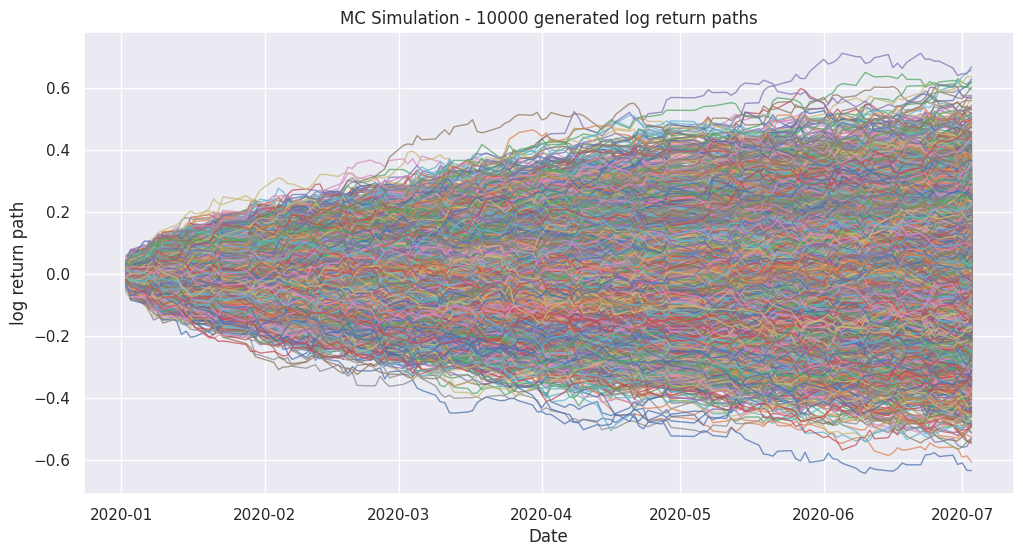

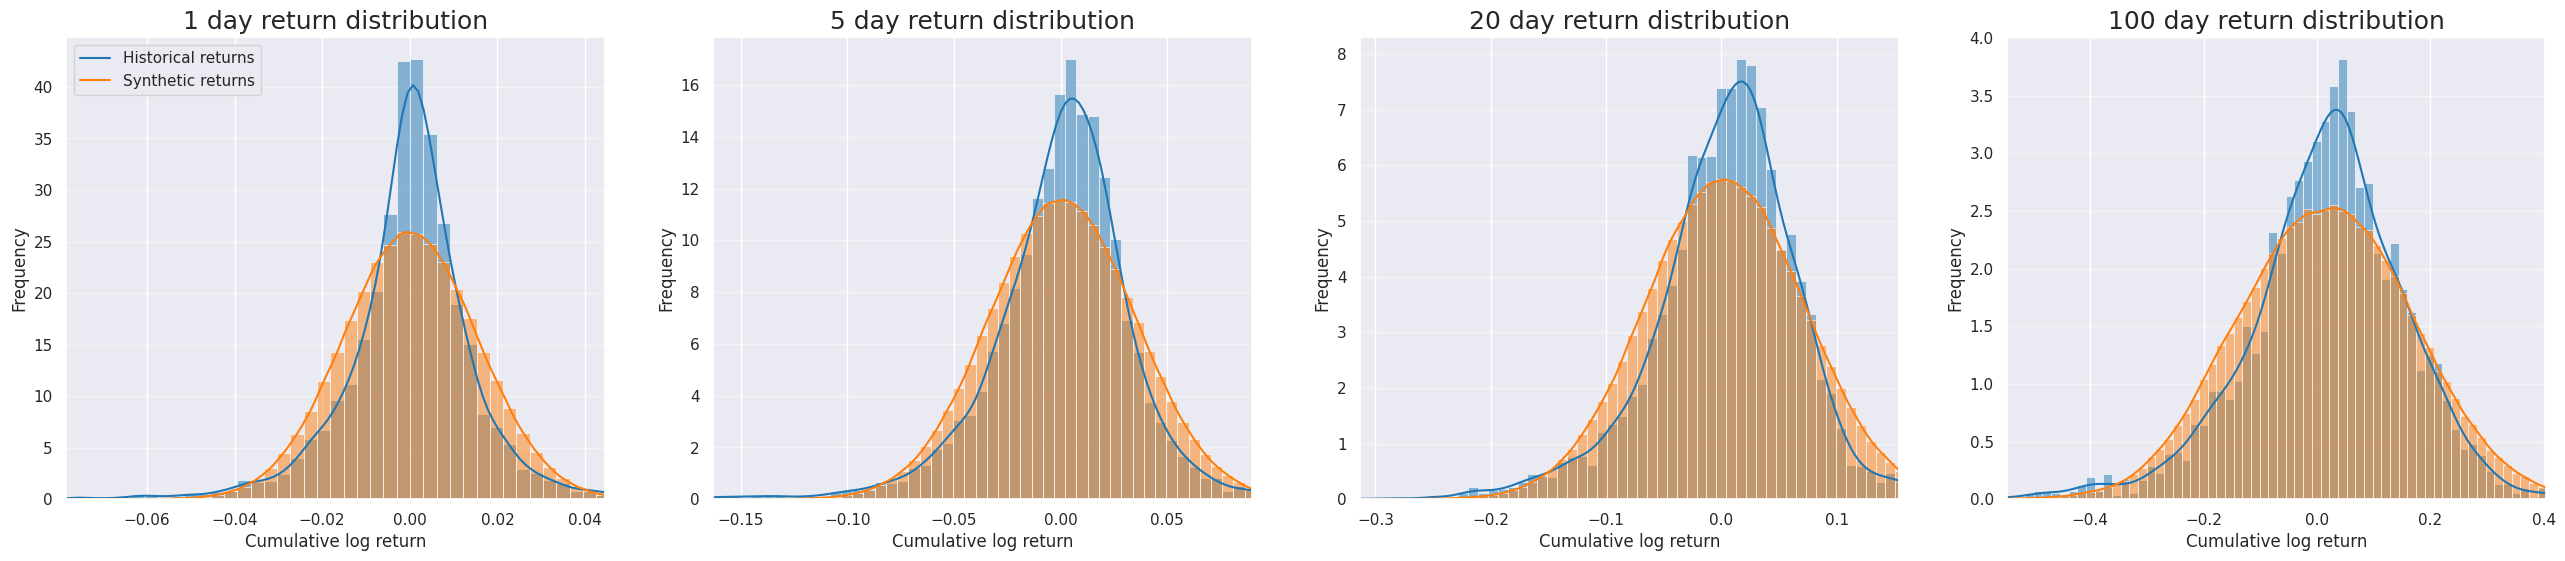

In [30]:
import numpy as np
import matplotlib.pyplot as plt

print(real[0].shape)
log_returns = real[0].reshape(-1)  # (4526, 1) 형식을 (4526,)로 변환

# 파라미터 설정
initial_price = data['Close'].values[0]
print("Initial price: ", initial_price)
#risk_free_rate = 0.03  # 무위험 이자율 (연 3%)
historical_mean = np.mean(log_returns) * 252  # 역사적 평균 수익률 (연율로 변환)
print('historica:', historical_mean)
sigma = np.std(log_returns) * np.sqrt(252) # 수익률의 표준 편차
print(sigma)
time_horizon = 252  # 시뮬레이션 기간 (252일 = 1년 기준)
num_simulations = 10000  # 시뮬레이션 횟수
delta_t = 1 / time_horizon  # 시간 간격 (1일)

# 시뮬레이션 결과를 저장할 배열 생성
simulated_prices = np.zeros((time_horizon, num_simulations))

# 초기 자산 가격 설정
simulated_prices[0] = initial_price

# 시뮬레이션 시작
for t in range(1, time_horizon):
    # 무작위 난수 생성 (정규분포 N(0,1))
    random_shocks = np.random.normal(0, 1, num_simulations)
    
    # 자산 가격 계산
    drift = (historical_mean ) * delta_t
    diffusion = sigma * random_shocks * np.sqrt(delta_t)
    simulated_prices[t] = simulated_prices[t - 1] * np.exp(drift + diffusion)

mc_returns = np.log(simulated_prices[1:] / simulated_prices[:-1])
mc_returns = np.transpose(mc_returns)[:, :126]
print(mc_returns.shape)

# # plot the 30 generated log return paths
for i in range(1):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(trading_days, np.cumsum(mc_returns[:10000], axis=1).T, alpha=0.75, linewidth=1.0)
    #ax.plot(np.cumsum(mc_returns[:10000], axis=1).T, alpha=0.75, linewidth=1.0)
    ax.set_title('MC Simulation - 10000 generated log return paths')
    ax.set_xlabel('Date')

    ax.set_ylabel('log return path')


windows = [1, 5, 20, 100]
for j in range(num_G):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
        fake_dist = rolling_window(mc_returns.T, windows[i]).sum(axis=0).ravel()

        min_val = real_dist.min()
        max_val = real_dist.max()
        
        # 동일한 bin 경계 계산 (간격 동일하게)
        bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
        sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .991]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])
    
plt.savefig(f'./Output/{sector}/{data_name}_MC.png', format='png', dpi=300, bbox_inches='tight')  
plt.show()

In [31]:
print(len(fake_list))
print(len(real_list))
print(fake_list[0].shape)
print(real_list[0].shape)
print(mc_returns.shape)

1
1
(10000, 126)
(4761, 126)
(10000, 126)


In [32]:
mc_list = []
mc_list.append(mc_returns)
print(mc_list[0].shape)

calculate_skew_kurt_diff(mc_list, real[0])
print(len(real_list))
len(fake_list)

(10000, 126)
Asset 1 Statistics:
  Fake Data (Daily) - Mean: 0.00015, Median: 0.00013, Std Dev: 0.01541
  Fake Data (Annualized) - Mean: 0.03766, Median: 0.03355, Std Dev: 0.24464
  Real Data (Daily) - Mean: -0.07615, Median: -0.07615, Std Dev: 0.00000
  Real Data (Annualized) - Mean: -19.18914, Median: -19.18914, Std Dev: 0.00000
  Fake Data - Skewness: -0.00099, Kurtosis: 2.95330
  Real Data - Skewness: nan, Kurtosis: nan
  Skewness Difference: nan
  Kurtosis Difference: nan
1


1

In [33]:
real[0].shape

(4887, 1)

In [34]:
print(np.mean(mc_list[0])*252)

0.03765542364791348


In [35]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Calculate EMD scores
results_emd = calculate_distribution_scores(real, mc_list, num_G, windows)
results_emd

{'EMD':               EMD 0  EMD_avg
 window size                 
 1            0.0029   0.0029
 5            0.0053   0.0053
 20           0.0102   0.0102
 100          0.0203   0.0203,
 'KL':                KL 0
 window size        
 1            0.1253
 5            0.0929
 20           0.0673
 100          0.0622,
 'JS':                JS 0
 window size        
 1            0.1488
 5            0.1211
 20           0.1159
 100          0.1200,
 'KS':                KS 0
 window size        
 1            0.0860
 5            0.0676
 20           0.0728
 100          0.0707}

In [36]:
acf_score = calculate_acf_score(real_list, mc_list)

# Display the scores for each group
for group, scores in acf_score.items():
    print(f"{group}:")
    for title, score in scores.items():
        print(f"  {title}: {score}")
#calculate_leverage_effect(mc_list, real_list)

Group 1:
  Identity log returns: 0.0757
  Absolute log returns: 0.185
  Squared log returns: 0.1645


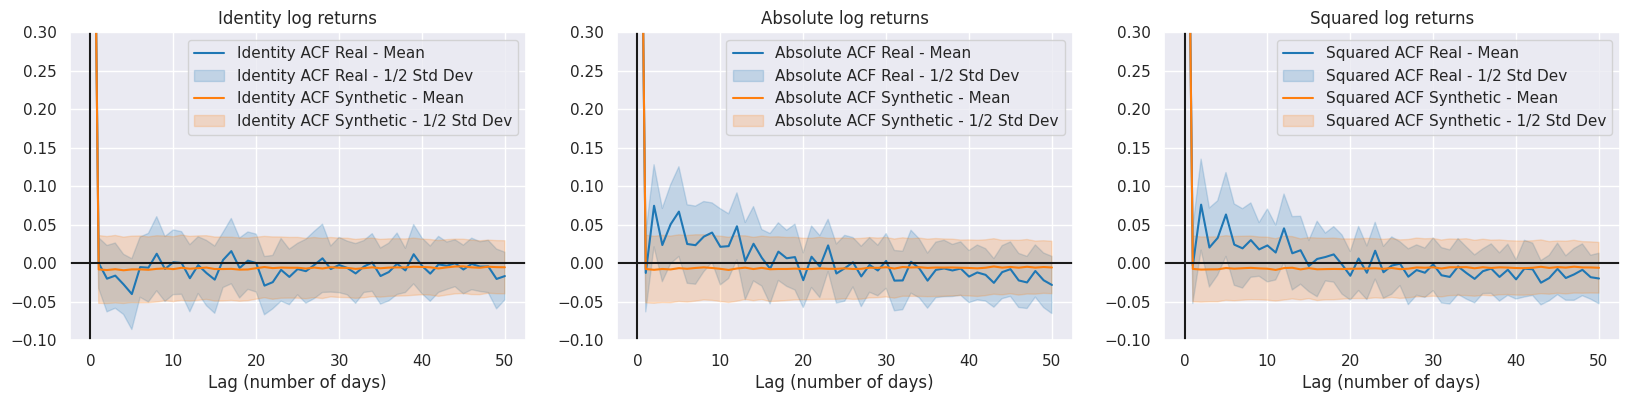

In [37]:
# ACF 비교 플롯
plot_acf_comparison(real_list, mc_list, num_G, lags=50)